# Inferring the Redshift Distribution of Gravitational Waves

# Hierarchical Likelihood Inference

In [66]:
import numpy as np
import pandas as pd
import json
import jax.numpy as jnp

with open(f"./event_posterior_samples.json", "r") as f:
    event_samples = {k:pd.DataFrame(v) for k,v in json.load(f).items()}

eventnames = []
posteriors = []
for event, posterior in event_samples.items():
    eventnames.append(event)
    posteriors.append(posterior)

In [67]:
with open(f"./selection_function_samples.json", "r") as f:
    selection_samples = pd.DataFrame(json.load(f))

selections_jaxed = {col: jnp.array(selection_samples[col][1:100]) for col in selection_samples.columns if col not in ['waveform_name', 'name']}

In [68]:
posteriors_jaxed = [{col: jnp.array(post[col][1:100]) for col in post.columns if col not in ['waveform_name']} for post in posteriors]

## Population Model Recap

We use individual event likelihoods to infer the hierarchical model. 
$$
\begin{equation}
p(\Lambda \mid d) \propto p(\Lambda)\prod_i^N \mathcal{L}\left(d_i \mid \Lambda\right)
\end{equation}
$$
where
$$
\begin{equation}
\mathcal{L}\left(d_i \mid \Lambda\right) \propto \int \frac{p\left(\theta \mid d_i\right) p(\theta \mid \Lambda)}{p(\theta)} d \theta \approx 
\left\langle  \frac{p(\theta \mid \Lambda)}{p(\theta)}  \right\rangle_{\sim p\left(\theta \mid d_i\right)}
\end{equation}
$$

We will "recycle" these posteriors and get the result for the following population model:


In [69]:
import jax.numpy as jnp
import jax

In [70]:
## Mass model
def power_law(x, L, a, b):
    normalization = (L + 1) / (jnp.power(b, L+1) - jnp.power(a, L+1))
    return jnp.power(x,L) * normalization

def trunc_normal_pdf(x, mu, sig, a, b):
    a_std, b_std = (a - mu) / sig, (b - mu) / sig
    return jax.scipy.stats.truncnorm.pdf(x, a_std, b_std, loc=mu, scale=sig)

In [71]:
class MassModel:
    def __init__(self, m_min, m_max):
        self.m_min = m_min
        self.m_max = m_max

    def pdf(self, data, params):
        p_m_power_law = power_law(data['mass_1_source'], params['lambda'], self.m_min, self.m_max)
        p_m_peak = trunc_normal_pdf(data['mass_1_source'], params['mu_m'], params['sigma_m'], self.m_min, self.m_max)
        p_q = power_law(data['mass_ratio'], params['gamma'], self.m_min/data['mass_1_source'], 1.0)
        p_m = params['fp'] * p_m_power_law + (1 - params['fp']) * p_m_peak
        return p_m*p_q

    def __call__(self, data, params):
        return self.pdf(data, params)

In [72]:
class Redshift:
    def __init__(self, z_max):
        from astropy.cosmology import Planck15
        self.z = jnp.linspace(0,z_max,300)
        self.y = Planck15.differential_comoving_volume(self.z).value * 4 * np.pi
        self.kappas = jnp.linspace(-10,10,3000)
        self._kappa_norms = None

    def dVdz(self, z):
        return jnp.interp(z, self.z, self.y)

    def normalization_func(self, z, kappa):
        return (1 + z)**(kappa - 1) * self.dVdz(z)

    @property
    def kappa_norms(self):
        if self._kappa_norms is None:
            self._normalize()
        return self._kappa_norms

    def _normalize(self):
        self._kappa_norms = jnp.array([jax.scipy.integrate.trapezoid(self.normalization_func(self.z, float(self.kappas[i])), self.z) for i in range(len(self.kappas))])

    def normalization(self, kappa):
        return jnp.interp(kappa, self.kappas, self.kappa_norms)
    
    def __call__(self, data, params):
        un_normalized = self.dVdz(data['redshift']) * ((1 + data['redshift']) ** (params["kappa"]-1))
        return un_normalized#/self.normalization(params['kappa'])

In [73]:
R = Redshift(1.9)
M = MassModel(2.0, 100.0)

In [74]:
jnp.log(0)

Array(-inf, dtype=float32, weak_type=True)

In [75]:
Lambda_0 = {'lambda' : 0.35, "gamma": 1.1, 'fp':0.98, 'mu_m':33.0, 'sigma_m':4.0, 'kappa':2.9}

class CustomLikelihood:
    def __init__(self, all_posteriors, selections, domain_changer=None):
        self.all_posteriors = all_posteriors
        self.selections = selections
        self.domain_changer = domain_changer

    def logpdf(self, x):
        #x = self.domain_changer.inverse_transform(x, suffix='')

        #event_likelihoods = jnp.sum(jnp.array([jnp.log(jnp.mean( ( R(post, x) / post["prior"]) )) for post in self.all_posteriors]))
        #selection_effects = -len(self.all_posteriors) * jnp.log( jnp.mean(  R(self.selections, x) / self.selections["prior"]) )

        event_likelihoods = jnp.sum(jnp.array([jax.scipy.special.logsumexp( (jnp.log(M(post, x)) + jnp.log(R(post, x)) - jnp.log(post["prior"])) ) for post in self.all_posteriors]))
        selection_effects = -len(self.all_posteriors) * jax.scipy.special.logsumexp( jnp.log(M(self.selections, x)) + jnp.log(R(self.selections, x)) - jnp.log(self.selections["prior"]))
        return event_likelihoods + selection_effects

In [76]:
xx = Lambda_0
[jax.scipy.special.logsumexp( (jnp.log(M(post, xx)) + jnp.log(R(post, xx)) - jnp.log(post["prior"])) ) for post in CL.all_posteriors]

[Array(29.063528, dtype=float32),
 Array(29.296207, dtype=float32),
 Array(28.730988, dtype=float32),
 Array(30.026285, dtype=float32)]

In [77]:
jnp.log(M(CL.selections, xx)) 
#CL.selections
#+ jnp.log(R(CL.selections, xx)) - jnp.log(CL.selections["prior"])

Array([-4.0744343, -3.7781596, -4.3720403, -4.3257694, -4.364632 ,
       -4.5319657, -4.003056 , -3.9459348, -4.3209996, -4.299395 ,
       -4.5517774, -3.7515955, -4.5385385, -4.3292427, -3.8373022,
       -4.865652 , -4.2302246, -5.0901227, -4.623945 , -3.788977 ,
       -4.393778 , -4.451396 , -4.04531  , -5.025048 , -4.018203 ,
       -4.133718 , -4.1728706, -3.652748 , -3.8870146, -4.0651493,
       -4.0294333, -4.166397 , -3.8068519, -5.4486375, -4.0564566,
       -4.494532 , -4.8225727, -4.025822 , -4.078074 , -4.556605 ,
       -4.4665117, -3.8687031, -4.685015 , -3.9500036, -4.0441437,
       -3.7761753, -4.353337 , -4.2116346, -4.4858165, -4.146921 ,
       -3.906707 , -4.157193 , -4.1976175, -4.3187466, -4.3017416,
       -4.750317 , -4.014643 , -4.7964463, -4.20704  , -4.509666 ,
       -5.0779543, -4.0109224, -4.610865 , -4.154706 , -4.5682025,
       -4.5149727, -4.3083477, -4.4953356, -4.1376243, -4.380774 ,
       -4.1108646, -4.0744257, -4.3313   , -3.7708158, -3.8645

In [78]:
from bayesian_inference import NUTS, MHSampler
import jax

 #DC = DomainChanger()
limits = {'lambda' : [-5,2], "gamma": [-3,3], 'fp':[0,1], 'mu_m':[10,50], 'sigma_m':[3,10], 'kappa':[0,10]}
#DC = DomainChanger(limits)

Lambda_0 = {'lambda' : -2.35, "gamma": 1.1, 'fp':0.98, 'mu_m':33.0, 'sigma_m':4.0, 'kappa':2.9}
#DC.transform_in_place(Lambda_0)
#Lambda_0

In [79]:
CL = CustomLikelihood(posteriors_jaxed, selections_jaxed)

In [80]:
print(CL.logpdf(Lambda_0))
new = jax.grad(CL.logpdf)
new(Lambda_0)
#new(kappa_0)

-498.0


{'fp': Array(115.28646, dtype=float32, weak_type=True),
 'gamma': Array(-6.5014105, dtype=float32, weak_type=True),
 'kappa': Array(-0.32410687, dtype=float32, weak_type=True),
 'lambda': Array(-5.3908014, dtype=float32, weak_type=True),
 'mu_m': Array(-0.3315344, dtype=float32, weak_type=True),
 'sigma_m': Array(1.5914199, dtype=float32, weak_type=True)}

In [81]:
N = NUTS(CL, Lambda_0, limits=limits, step_size=0.1)

2023-12-05 18:17:06.258953: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-12-05 18:18:53.869471: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m47.615059s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [ ]:
result = N.run(100)

Running the inference for 100 samples


In [ ]:
df = pd.DataFrame(result)

In [ ]:
df

In [92]:
N.domain_changer.inverse_transforms['fp'](N.states.position['fp']);

In [104]:
thefunc = {key: (lambda x, key=key: f"{key}" ) for key in N.domain_changer.ranges.keys()}

thefunc['fp']('asad')

'fp'

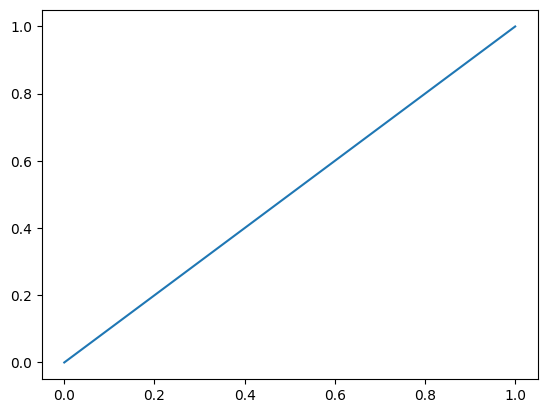

In [44]:

test_func = lambda x: N.domain_changer.inverse_transform_from_infinite(N.domain_changer.transform_to_infinite(x, 0, 1), 0, 1)

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,1,100),  test_func(np.linspace(0,1,100)))

In [53]:
result_transformed = {k:jnp.array(result[k]) for k in result.copy().columns}
CL.domain_changer.inverse_transform_in_place(result_transformed)
result_transformed = pd.DataFrame(result_transformed)

In [56]:
result

,fp,gamma,kappa,lambda,mu_m,sigma_m
0,-48.664772,-60.587166,304.759216,502.089325,12.630095,75.958687
1,-79.967819,-51.738228,420.871521,306.243378,6.227320,69.513924
2,-72.176231,-51.131386,422.118530,295.722443,7.424504,70.870544
3,-26.729658,-81.329216,699.901550,260.087189,60.403507,68.422508
4,-5.078474,-33.296501,1028.398315,63.173100,46.668640,82.971046
...,...,...,...,...,...,...
995,466.398560,310.527985,796.583740,-53.908718,752.968811,1484.310425
996,465.000519,312.826385,801.687073,-81.881317,763.814575,1500.555176
997,468.122314,310.471375,834.728027,-85.735611,766.050659,1489.450928
998,493.003967,332.404114,967.518677,-29.848114,791.934082,1519.297119


In [21]:
from bayesian_inference import NUTS
import jax
import jax.numpy as jnp

class LinearRegressor:
    def __init__(self, X, Y, noise=1):
        self.X = X
        self.Y = Y
        self.noise = noise

    def logpdf(self, x):
        Z = (self.Y - x['m']*self.X - x['c'])/self.noise
        return jnp.sum(-(Z**2))/2 


key = jax.random.PRNGKey(1)

m = 2.0
c = 2.0
X = jnp.linspace(0,10,100)
noise_amount = 1.0
eps = noise_amount*jax.random.normal(key, X.shape)

Y = m*X + c + eps

LR = LinearRegressor(X,Y,noise=noise_amount)  # Instantiate the model

initial_position = {'m':0.1, 'c':0.0} # starting point of the NUTS sampler
problem = NUTS(LR, initial_position, limits={'m': [-4,4], 'c':[-4,4]})

{'m': Array([0.1], dtype=float32), 'c': Array([0.], dtype=float32)} {'m': Array([0.05001042], dtype=float32), 'c': Array([0.], dtype=float32)}


In [22]:
problem.likelihood_func( problem.domain_changer.transform(initial_position) )

Array(-8175.563, dtype=float32)

In [23]:
problem.likelihood.logpdf(initial_position)

Array(-8176.9478, dtype=float32)

In [24]:
result1 = problem.run(1000)

Running the inference for 1000 samples


array([[<Axes: title={'center': 'm'}>, <Axes: title={'center': 'c'}>]],
      dtype=object)

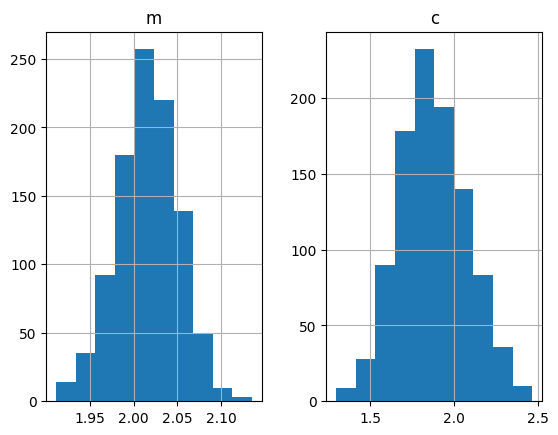

In [25]:
import pandas as pd
#pd.DataFrame(problem.domain_changer.inverse_transform(problem.states.position)).hist()
result1.hist()

## Using Metropolis Hastings & JAX

In [44]:
from bayesian_inference import NUTS, MHSampler
import jax
import jax.numpy as jnp
import scipy

class CoinFlip:
    def __init__(self, N_flips, number_of_heads):
        self.head_counts = number_of_heads 
        self.N_flips = N_flips

    def logpdf(self, x):
        p = x['p']
        return jnp.sum( jax.scipy.stats.binom.logpmf(self.head_counts, self.N_flips, p) )
        


key = jax.random.PRNGKey(1)


N_experiments = 100
N_flips = 10
p = 0.7

import scipy
rv = scipy.stats.binom(N_flips, p)
head_counts = jnp.array(rv.rvs(N_experiments))

#CoinFlip(10, head_counts).logpdf({'p':0.7})
#LR = LinearRegressor(X,Y,noise=noise_amount)  # Instantiate the model

#initial_position = {'m':0.1, 'c':0.0} # starting point of the NUTS sampler
#problem = NUTS(LR, initial_position, limits={'m': [-4,4], 'c':[-4,4]})

In [45]:
CF = CoinFlip(10, head_counts)

initial_position = {'p':0.1, 'mu': jnp.array([0.2,0.4,0.1, 0.4,0.2, 0.1]).reshape((2,3))} # starting point of the NUTS sampler
problem2 = MHSampler(CF, initial_position, limits={'p': [0,1], 'mu': [0.0, 1.0]}, step_size=0.1, backend='JAX');

In [46]:
result2 = problem2.run(1000);

Getting 1000 using Metropolis Hastings


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 189.14it/s]


Sampling finished with an acceptance rate of 56.5


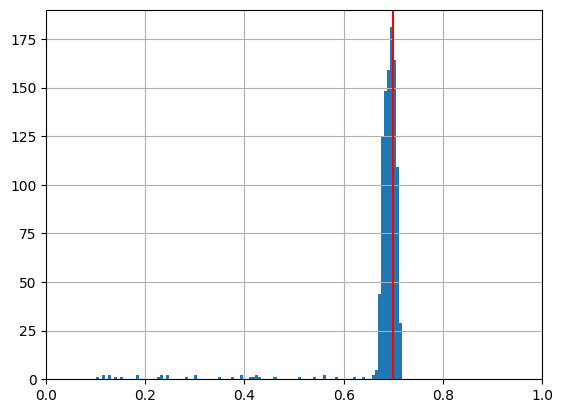

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
result = pd.DataFrame(result2)

result['p'].hist(bins=100)
plt.xlim((0,1))
plt.axvline(p, c='r')
plt.show()

## Using NUTS & JAX

In [48]:
CF = CoinFlip(10, head_counts)

initial_position = {'p':0.1, 'mu': jnp.array([0.2,0.4,0.1, 0.4,0.2, 0.1])} # starting point of the NUTS sampler
problem2 = NUTS(CF, initial_position, limits={'p': [0,1], 'mu': [0.0, 1.0]});

In [49]:
result2 = problem2.run(1000);

Running the inference for 1000 samples


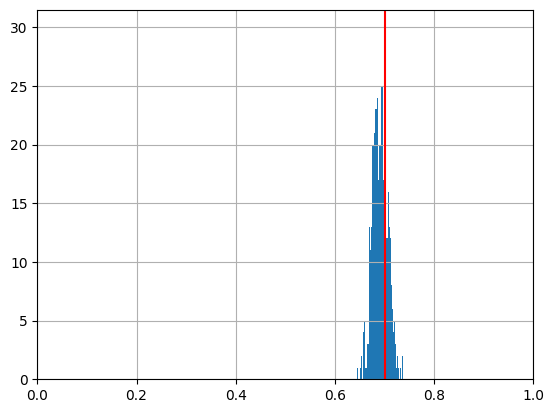

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
result = pd.DataFrame(result2)

result['p'].hist(bins=100)
plt.xlim((0,1))
plt.axvline(p, c='r')
plt.show()

## Using Metropolis Hastings & Numpy

In [34]:
from bayesian_inference import NUTS, MHSampler
import scipy
import numpy as np
import jax
import jax.numpy as jnp

class CoinFlip:
    def __init__(self, N_flips, number_of_heads):
        self.head_counts = number_of_heads 
        self.N_flips = N_flips

    def logpdf(self, x):
        p = x['p']
        return np.sum( scipy.stats.binom.logpmf(self.head_counts, self.N_flips, p) )
        


#key = jax.random.PRNGKey(1)


N_experiments = 100
N_flips = 10
p = 0.9

import scipy
rv = scipy.stats.binom(N_flips, p)
head_counts = np.array(rv.rvs(N_experiments))

#CoinFlip(10, head_counts).logpdf({'p':0.7})
#LR = LinearRegressor(X,Y,noise=noise_amount)  # Instantiate the model

#initial_position = {'m':0.1, 'c':0.0} # starting point of the NUTS sampler
#problem = NUTS(LR, initial_position, limits={'m': [-4,4], 'c':[-4,4]})

In [35]:
head_counts

array([ 9,  7, 10, 10,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10,  9,  8, 10,
        9,  7, 10,  9,  9,  9,  9,  9,  8,  9,  9,  8, 10, 10,  9,  9,  9,
        9,  9,  9,  8,  8,  8,  9,  7,  7,  8,  9,  9,  9,  8,  8,  9,  9,
        9,  8,  9, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  7,  9,  8,  9,
       10,  8, 10,  8,  9,  9, 10,  7,  9, 10, 10, 10,  9,  9,  7,  9, 10,
        9,  9,  9,  7, 10,  8,  9, 10,  9, 10,  6, 10, 10, 10, 10])

In [36]:
import numpy as np
CF = CoinFlip(10, head_counts)

initial_position = {'p':0.4, 'q': np.array([0.1,0.2])} # starting point of the NUTS sampler
problem2 = MHSampler(CF, initial_position, limits={'p': [0,1]}, step_size=0.1, backend='numpy')

In [37]:
hist = problem2.run(1000);

Getting 1000 using Metropolis Hastings


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 799.10it/s]


Sampling finished with an acceptance rate of 12.93


In [38]:
import pandas as pd
pd.DataFrame(hist)

,p,q
0,0.400000,"[0.1, 0.2]"
1,0.584997,"[0.030446364465971834, 0.03601920458102953]"
2,0.743444,"[0.04906714105716386, -0.07736697075775575]"
3,0.940916,"[0.02422663902888695, -0.03536362215722196]"
4,0.892183,"[-0.055472778492097245, -0.1004082952007738]"
...,...,...
995,0.908755,"[3.109852834412593, -3.356917661252733]"
996,0.903126,"[3.1560352460698073, -3.5156675730422884]"
997,0.879210,"[3.101863777770636, -3.655658110827405]"
998,0.908463,"[3.0573320433935285, -3.6234965769590564]"


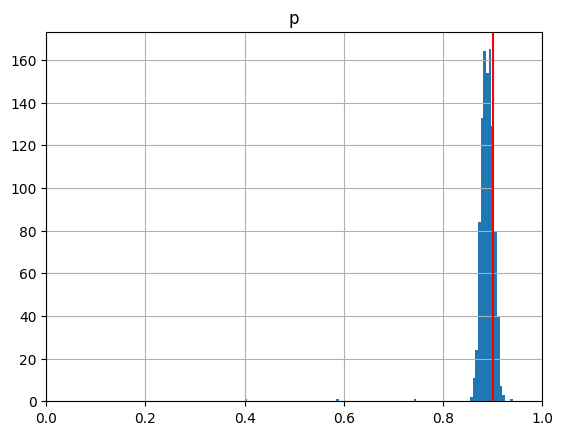

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(hist).hist(bins=100)
plt.xlim((0,1))
plt.axvline(p, c='r')